# PUT THE TEXT inside this section IN A README(TO BE DELETED)




## Dataset Preparation Script

This script downloads metadata from the ISIC API, extracts lesion images from ZIP archives, filters metadata based on available image files, and generates reproducible train/validation/test splits grouped by patient ID.

### Requirements

Python 3.7 or higher with the following packages installed: `pandas`, `numpy`, `requests`, `scikit-learn`.

Install them using:

```bash
pip install pandas numpy requests scikit-learn
```
### Important Note

All ZIP files must be placed in the same directory before running the script. These ZIP files are a required prerequisite and are **not downloaded automatically** by the script. You can download them from the [ISIC 2018 Challenge (Task 3)](https://challenge.isic-archive.com/data/#2018) or from our [GitHub repository](https://github.com/PedroDiz/AP-2025/tree/main).

### Usage

To run the script when ZIP files are in the same directory as the program:
```bash
python prepare_data.py --zip_dir . --output_dir data_v1 --image_dir ISIC_IMAGES --seed 42
```

### Arguments

Path to the directory containing ZIP files with `.jpg` images. **Required**.

```bash
--zip_dir
```

Directory where the output CSV files will be saved. Default is `data_cache`.

```bash
--output_dir
```

Random seed for reproducibility. Default is `42`.

```bash
--seed
```

### Output

The script creates the following files inside the specified output directory:

- lesions.csv — the full cleaned dataset
- lesions_train.csv — training subset
- lesions_val.csv — validation subset
- lesions_test.csv — test subset

All corresponding images are extracted to the specified image directory (`ISIC_IMAGES` by default).


In [ ]:
#!python prepare_data.py --zip_dir . --output_dir data_v1 --image_dir ISIC_IMAGES

#GET FILES FROM THE DRIVE(local testing)/TO BE DELETED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

PATH_ZIP = "/content/drive/MyDrive/ZIPS_DATA"
PATH_SCRIPT = "/content/drive/MyDrive/prepare_data.py"

Mounted at /content/drive


In [ ]:
os.makedirs("checkpoints", exist_ok=True)

In [ ]:

!python "{PATH_SCRIPT}" --zip_dir "{PATH_ZIP}" --output_dir data_v1

Extracting images from ZIP files in: /content/drive/MyDrive/ZIPS_DATA
Extracted 11730 images to 'ISIC_IMAGES'.
Fetching metadata from ISIC API...
Collected 11720 metadata entries.
Building dataframe from metadata and filtering by extracted images...
Train: 6117 patients, 8180 samples
  Benign 81.0% | Malignant 19.0%

Val: 1311 patients, 1694 samples
  Benign 82.8% | Malignant 17.2%

Test: 1311 patients, 1697 samples
  Benign 81.9% | Malignant 18.1%



#Imports

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.9 MB/s e

In [381]:
# Standard library
import os
import time
import random
from datetime import datetime

# Data handling
import requests
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

# PyTorch & vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import timm
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from torch.amp import autocast, GradScaler
# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Scikit-learn metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve,recall_score,
    f1_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    precision_recall_curve,
    confusion_matrix
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [382]:
import numpy as np
from PIL import Image

def shades_of_gray(img: Image.Image, illuminant: str = "gray_world", p: float = 6.0) -> Image.Image:
    """
    Applies Shades-of-Gray color constancy to a PIL image.

    Args:
        img:      PIL.Image in RGB mode.
        illuminant: Only "gray_world" is supported here.
        p:        Minkowski norm power (commonly between 4 and 8).

    Returns:
        A new PIL.Image with color-corrected pixels.
    """
    assert img.mode == "RGB", "Image must be in RGB mode"
    # 1) Convert to float32 array, scale [0,1]
    arr = np.asarray(img).astype(np.float32) / 255.0

    # 2) Compute the Minkowski p‐norm per channel
    #    m_c = ( mean( channel^p ) )^(1/p)
    m = np.mean(arr**p, axis=(0,1))**(1.0/p)  # shape (3,)

    # 3) Compute scaling factors so that after correction the illuminant is gray
    #    scale = mean(m) / m_c
    mean_m = np.mean(m)
    scale = mean_m / m

    # 4) Apply scales
    arr_corrected = arr * scale[None,None,:]

    # 5) Clip back to [0,1], convert to uint8
    arr_corrected = np.clip(arr_corrected, 0.0, 1.0)
    img_out = Image.fromarray((arr_corrected * 255).astype(np.uint8), mode="RGB")
    return img_out


# Dataset & Dataloaders

The dataset is imbalanced, with the majority of images representing benign (non-cancerous) skin lesions.

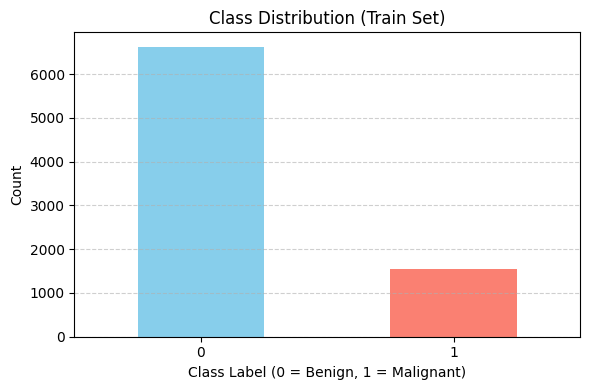

In [383]:
df = pd.read_csv("data_v1/lesions_train.csv")  # or lesions_val.csv, lesions.csv, etc.

plt.figure(figsize=(6, 4))
df['label'].value_counts().sort_index().plot(kind='bar', color=["skyblue", "salmon"])

plt.title("Class Distribution (Train Set)")
plt.xlabel("Class Label (0 = Benign, 1 = Malignant)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


This custom `SkinCancerDataset` class wraps our image DataFrame for PyTorch:

- **`dataframe`**: Pandas DataFrame containing `file`, `patient`, and `label` columns.  
- **`image_dir`**: Directory where the images (`<isic_id>.jpg`) are stored.  
- **`transform`**: A `torchvision.transforms.Compose` object for preprocessing and (optionally) augmentations.  
- **`return_filename`**: If `True`, `__getitem__` returns `(image, label, filename)`, useful for logging .

In [384]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None, return_filename=False):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.return_filename = return_filename

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["file"])
        label = torch.tensor(row["label"], dtype=torch.float32)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.return_filename:
            return image, label, row["file"]
        else:
            return image, label

Augmentation and pre-processing

In [385]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(300, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

"""
train_transform = transforms.Compose([
   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),
    transforms.RandomResizedCrop(224),   # or 300 for B3
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])"""

'\ntrain_transform = transforms.Compose([\n   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),\n    transforms.RandomResizedCrop(224),   # or 300 for B3\n    transforms.RandomHorizontalFlip(),\n    transforms.RandomVerticalFlip(),\n    transforms.RandomRotation(15),\n    transforms.ColorJitter(0.1, 0.1, 0.1),\n    transforms.ToTensor(),\n    transforms.Normalize([0.5]*3, [0.5]*3),\n])\n\nval_transform = transforms.Compose([\n   # transforms.Lambda(lambda img: shades_of_gray(img, illuminant="gray_world", p=6.0)),\n    transforms.Resize(224),\n    transforms.CenterCrop(224),\n    transforms.ToTensor(),\n    transforms.Normalize([0.5]*3, [0.5]*3),\n])'

Wrap `SkinCancerDataset` in a PyTorch `DataLoader`

In [386]:
PATH = "/content/ISIC_IMAGES"

# Load CSVs generated by prepare_data.py
train_df = pd.read_csv("data_v1/lesions_train.csv")
val_df   = pd.read_csv("data_v1/lesions_val.csv")
test_df = pd.read_csv("data_v1/lesions_test.csv")

train_dataset = SkinCancerDataset(
    train_df,
    PATH,
    transform=train_transform,
    return_filename=False
)

# Compute weights for class-balanced sampling (70/30 ratio)
p_m = train_df["label"].mean()
w_benign    = 0.6 / (1.0 - p_m)
w_malignant = 0.4 / p_m

sample_weights = train_df["label"].map({
    0: w_benign,
    1: w_malignant
}).values

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_dataset = SkinCancerDataset(
    val_df,
    PATH,
    transform=val_transform,
    return_filename=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)


test_dataset = SkinCancerDataset(
    test_df,
    PATH,
    transform=val_transform,
    return_filename=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Model, Loss, Optimizer & Scheduler

Instantiate a pretrained EfficientNet-B0 model with a single output neuron for binary (benign vs. malignant) classification.  

In [375]:
"""
model = timm.create_model(
    "efficientnetv2_s",
    pretrained=True,
    num_classes=1
)
"""
"""
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=1
)


"""


'\nmodel = timm.create_model(\n    "efficientnet_b0",\n    pretrained=True,\n    num_classes=1\n)\n\n\n'

Focal Binary Cross‐Entropy (Focal BCE) loss down‐weights easy examples and focuses training on hard, misclassified samples.







In [387]:
class FocalBCELoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=0.5, reduction="mean", use_focal=True):
        """
        alpha: weight for the positive (malignant) class (0 < alpha < 1)
               smaller alpha → less emphasis on positives
        gamma: focusing parameter (≥0), smaller → less focus on hard examples
        reduction: 'mean' or 'sum'
        use_focal: if False, falls back to plain BCEWithLogitsLoss
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.use_focal = use_focal

        if self.use_focal:
            # keep one BCE-with-logits loss per example for focal computation
            self.bce = nn.BCEWithLogitsLoss(reduction='none')
        else:
            # if not using focal, just use standard BCEWithLogitsLoss with reduction
            self.bce = nn.BCEWithLogitsLoss(reduction=self.reduction)

    def forward(self, logits, targets):
        # logits: raw model outputs (no sigmoid), shape [batch_size]
        # targets: ground-truth labels (0.0 or 1.0), shape [batch_size]

        if not self.use_focal:
            # simple binary cross-entropy on logits
            return self.bce(logits, targets)

        # 1. Compute per-example BCE loss (no reduction)
        bce_loss = self.bce(logits, targets)  # shape [batch_size]

        # 2. Convert logits to probabilities in [0,1]
        prob = torch.sigmoid(logits)          # shape [batch_size]

        # 3. p_t: model's probability of the true class
        #    for positive: prob; for negative: 1 - prob
        p_t = prob * targets + (1 - prob) * (1 - targets)

        # 4. alpha factor: alpha for positives, (1 - alpha) for negatives
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # 5. focal factor: (1 - p_t)^gamma — focuses on hard (uncertain) examples
        focal_factor = (1 - p_t) ** self.gamma

        # 6. Combine: alpha * focal * bce
        loss = alpha_factor * focal_factor * bce_loss  # shape [batch_size]

        # 7. Reduce to scalar
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # return per-example losses if reduction is None


**Training configuration:**  
- **Loss:** Focal Binary Cross‐Entropy.  
- **Optimizer:** AdamW (learning rate = 3e-4, weight decay = 1e-4).  
- **LR Scheduler:** Cosine annealing over 30 epochs (`T_max=30`).  


In [389]:
# — Hyper-parameters —
n_epochs      = 20
freeze_epochs = 3
lr_head       = 3e-4
lr_backbone   = 1e-4
weight_decay  = 1e-4
accum_steps   = 2  # 32 × 2 = effective batch 64

# — Model, loss, device —
model = timm.create_model(
    "efficientnet_b3",
    pretrained=True,
    num_classes=1
)
criterion = FocalBCELoss(gamma=2, alpha=0.6)
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# — 1) Freeze stem + block0 for warm-up —
for p in model.conv_stem.parameters():
    p.requires_grad = False
for p in model.blocks[0].parameters():
    p.requires_grad = False

# — 2) Build optimizer with two LR groups —
head_params     = list(model.classifier.parameters())
backbone_params = [p for n, p in model.named_parameters() if "classifier" not in n]

optimizer = AdamW(
    [
        {"params": head_params,     "lr": lr_head},
        {"params": backbone_params, "lr": lr_backbone}
    ],
    weight_decay=weight_decay
)

# — 3) AMP scaler & scheduler —
scaler    = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

# — Reset GPU stats if on CUDA —
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)


# Training & Validation Helper Functions

In [390]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2



def apply_mixup_or_cutmix(x, y, alpha=0.2, mode=None):
    """
    Applies MixUp or CutMix to a batch of images and labels.

    Args:
        x (Tensor): batch of images (B, C, H, W)
        y (Tensor): batch of labels (B,)
        alpha (float): beta distribution parameter
        mode (str or None): 'mixup', 'cutmix', or None

    Returns:
        x_aug (Tensor): augmented images
        y_a (Tensor): original labels
        y_b (Tensor): shuffled labels
        lam (float): mix ratio
    """
    if mode is None:
        return x, y, y, 1.0  # no mixup/cutmix

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    y_a = y
    y_b = y[rand_index]
    x2 = x[rand_index]

    if mode == 'mixup':
        x = lam * x + (1 - lam) * x2
    elif mode == 'cutmix':
        bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
        x[:, :, bbx1:bbx2, bby1:bby2] = x2[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby1 - bby2) / (x.size(-1) * x.size(-2)))
    else:
        raise ValueError(f"Invalid mode: {mode}")

    return x, y_a, y_b, lam

def apply_random_mix(x, y, alpha=0.4, prob_mixup=0.5, prob_cutmix=0.3):
    """
    Randomly applies MixUp, CutMix, or nothing to the batch.
    """
    p = np.random.rand()
    if p < prob_mixup:
        return apply_mixup_or_cutmix(x, y, alpha, mode="mixup")
    elif p < prob_mixup + prob_cutmix:
        return apply_mixup_or_cutmix(x, y, alpha, mode="cutmix")
    else:
        return x, y, y, 1.0  # no mixing


In [391]:
USE_MIXUP = False

def train_one_epoch(loader, model, criterion, optimizer, scaler, device, accum_steps, use_mixup=True):
    model.train()
    running_loss = 0.0
    logits_all, probs_all, labels_all = [], [], []

    optimizer.zero_grad()
    pbar = tqdm(loader, desc="  [Train]   ", leave=False)
    for i, (X, y) in enumerate(pbar):
        X, y = X.to(device), y.to(device)

        with autocast(device_type="cuda"):
            if use_mixup:
                X_m, y_a, y_b, lam = apply_mixup_or_cutmix(X, y, mode="mixup")
                logits = model(X_m).squeeze()
                raw_loss = lam * criterion(logits, y_a.float()) + (1 - lam) * criterion(logits, y_b.float())
            else:
                logits = model(X).squeeze()
                raw_loss = criterion(logits, y.float())

            loss = raw_loss / accum_steps

        scaler.scale(loss).backward()

        if (i + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        batch_size = X.size(0)
        running_loss += raw_loss.item() * batch_size
        logits_all.extend(logits.detach().cpu().numpy())
        probs_all.extend(torch.sigmoid(logits).detach().cpu().numpy())
        labels_all.extend(y.cpu().numpy())

        pbar.set_postfix({
            "loss": f"{raw_loss.item():.3f}",
            "lr": optimizer.param_groups[0]['lr']
        })

    if len(loader) % accum_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    avg_loss = running_loss / len(loader.dataset)
    train_auroc = roc_auc_score(labels_all, probs_all)
    return avg_loss, logits_all, probs_all, labels_all, train_auroc

def validate_one_epoch(loader):
    model.eval()
    logits_all, labels_all, files_all = [], [], []

    with torch.no_grad():
        for X, y, fn in tqdm(loader, desc="  [Validate]", leave=False):
            X = X.to(device)
            logits = model(X).squeeze()
            logits_all.extend(logits.cpu().numpy())
            labels_all.extend(y.numpy())
            files_all.extend(fn)

    y_true = np.array(labels_all)
    y_prob = torch.sigmoid(torch.tensor(logits_all)).cpu().numpy()
    val_loss = criterion(
        torch.tensor(logits_all),
        torch.tensor(labels_all)
    ).item()
    auroc    = roc_auc_score(y_true, y_prob)

    return val_loss, auroc, y_true, y_prob, files_all


#Main Training Loop

**Note about early stop**: In imbalanced medical datasets, loss can decrease even when model performance on the minority class (malignant) degrades. This leads to misleadingly optimistic results. AUROC, on the other hand, evaluates the model's ability to separate the two classes regardless of class imbalance or threshold, making it a more reliable early stopping criterion in this context.

In [ ]:

# — Metric & timing trackers —
epoch_times       = []
train_losses      = []
train_aurocs      = []
val_losses        = []
val_aurocs        = []
all_epoch_true    = []
all_epoch_prob    = []
all_epoch_files   = []
best_val_auroc    = 0.0
best_epoch        = 1

print("Starting training...\n")

for epoch in range(1, n_epochs + 1):
    # — Unfreeze at start of epoch 4 —
    if epoch == freeze_epochs + 1:
        print(">>> Unfreezing stem + block0 now")
        for p in model.conv_stem.parameters():
            p.requires_grad = True
        for p in model.blocks[0].parameters():
            p.requires_grad = True
        # no need to rebuild optimizer; param-groups are already set

    start = time.time()
    print(f"--- Epoch {epoch}/{n_epochs} ---")

    # === Train (with AMP & grad-acc inside train_one_epoch) ===
    train_loss, logits, probs, labels, train_auroc = train_one_epoch(
        train_loader,
        model,
        criterion,
        optimizer,
        scaler,
        device,
        accum_steps,
    )
    train_losses.append(train_loss)
    train_aurocs.append(train_auroc)

    # === Validate ===
    val_loss, val_auroc, y_true, y_prob, val_files = validate_one_epoch(val_loader)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)

    # === Store raw predictions for thresholding later ===
    all_epoch_true.append(y_true)
    all_epoch_prob.append(y_prob)
    all_epoch_files.append(val_files)

    # === Print summary ===
    print(f"Train Loss: {train_loss:.4f} | Train AUROC: {train_auroc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   AUROC: {val_auroc:.4f}\n")

    # === Scheduler step ===
    scheduler.step()

    # === Timing ===
    elapsed = time.time() - start
    epoch_times.append(elapsed)
    print(f"Epoch Time: {elapsed:.1f} sec\n")

    # === Save best model ===
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_epoch     = epoch
        torch.save(model.state_dict(), "checkpoints/best_model.pt")

print(f"Best AUROC {best_val_auroc:.4f} at epoch {best_epoch}")


Starting training...

--- Epoch 1/20 ---


Train Loss: 0.3772 | Train AUROC: 0.6551
Val   Loss: 0.2252 | Val   AUROC: 0.7959

Epoch Time: 128.2 sec

--- Epoch 2/20 ---


Train Loss: 0.1516 | Train AUROC: 0.6359
Val   Loss: 0.0922 | Val   AUROC: 0.8136

Epoch Time: 119.5 sec

--- Epoch 3/20 ---


Train Loss: 0.0777 | Train AUROC: 0.6901
Val   Loss: 0.0628 | Val   AUROC: 0.8390

Epoch Time: 120.7 sec

>>> Unfreezing stem + block0 now
--- Epoch 4/20 ---


Train Loss: 0.0637 | Train AUROC: 0.7005
Val   Loss: 0.0591 | Val   AUROC: 0.8613

Epoch Time: 127.6 sec

--- Epoch 5/20 ---


Train Loss: 0.0555 | Train AUROC: 0.7091
Val   Loss: 0.0467 | Val   AUROC: 0.8893

Epoch Time: 122.8 sec

--- Epoch 6/20 ---


Train Loss: 0.0532 | Train AUROC: 0.7215
Val   Loss: 0.0522 | Val   AUROC: 0.8836

Epoch Time: 121.6 sec

--- Epoch 7/20 ---


Train Loss: 0.0504 | Train AUROC: 0.7282
Val   Loss: 0.0496 | Val   AUROC: 0.8940

Epoch Time: 125.1 sec

--- Epoch 8/20 ---


Train Loss: 0.0503 | Train AUROC: 0.7191
Val   Loss: 0.0453 | Val   AUROC: 0.8958

Epoch Time: 124.9 sec

--- Epoch 9/20 ---


Train Loss: 0.0457 | Train AUROC: 0.7421
Val   Loss: 0.0420 | Val   AUROC: 0.8972

Epoch Time: 121.6 sec

--- Epoch 10/20 ---


Train Loss: 0.0478 | Train AUROC: 0.7427
Val   Loss: 0.0429 | Val   AUROC: 0.9028

Epoch Time: 122.2 sec

--- Epoch 11/20 ---


Train Loss: 0.0436 | Train AUROC: 0.7410
Val   Loss: 0.0423 | Val   AUROC: 0.9008

Epoch Time: 127.8 sec

--- Epoch 12/20 ---


Train Loss: 0.0460 | Train AUROC: 0.7244
Val   Loss: 0.0424 | Val   AUROC: 0.9033

Epoch Time: 125.5 sec

--- Epoch 13/20 ---


Train Loss: 0.0419 | Train AUROC: 0.7416
Val   Loss: 0.0413 | Val   AUROC: 0.9023

Epoch Time: 125.8 sec

--- Epoch 14/20 ---


Train Loss: 0.0401 | Train AUROC: 0.7354
Val   Loss: 0.0416 | Val   AUROC: 0.9060

Epoch Time: 124.3 sec

--- Epoch 15/20 ---


Train Loss: 0.0390 | Train AUROC: 0.7456
Val   Loss: 0.0405 | Val   AUROC: 0.9057

Epoch Time: 117.4 sec

--- Epoch 16/20 ---


Train Loss: 0.0385 | Train AUROC: 0.7377
Val   Loss: 0.0399 | Val   AUROC: 0.9045

Epoch Time: 117.7 sec

--- Epoch 17/20 ---


Train Loss: 0.0390 | Train AUROC: 0.7450
Val   Loss: 0.0413 | Val   AUROC: 0.9021

Epoch Time: 114.9 sec

--- Epoch 18/20 ---


Train Loss: 0.0368 | Train AUROC: 0.7238
Val   Loss: 0.0404 | Val   AUROC: 0.9048

Epoch Time: 115.2 sec

--- Epoch 19/20 ---


Train Loss: 0.0393 | Train AUROC: 0.7575
Val   Loss: 0.0397 | Val   AUROC: 0.9031

Epoch Time: 117.3 sec

--- Epoch 20/20 ---


Train Loss: 0.0388 | Train AUROC: 0.7508
Val   Loss: 0.0401 | Val   AUROC: 0.9054

Epoch Time: 117.5 sec

Best AUROC 0.9060 at epoch 14


#Learning Curves & Helper functions and Metric analysis

In [ ]:
history = pd.DataFrame({
    "epoch":       list(range(1, n_epochs+1)),
    "train_loss":  train_losses,
    "train_auroc": train_aurocs,
    "val_loss":    val_losses,
    "val_auroc":   val_aurocs,
})



In [ ]:
best_auroc_epoch   = history["val_auroc"].idxmax() + 1
print(f"Best AUROC:   {history.val_auroc.max():.4f} at epoch {best_auroc_epoch}")
best_epoch = best_auroc_epoch


Best AUROC:   0.9060 at epoch 14


**Loss vs. Epoch**

<Figure size 640x480 with 0 Axes>

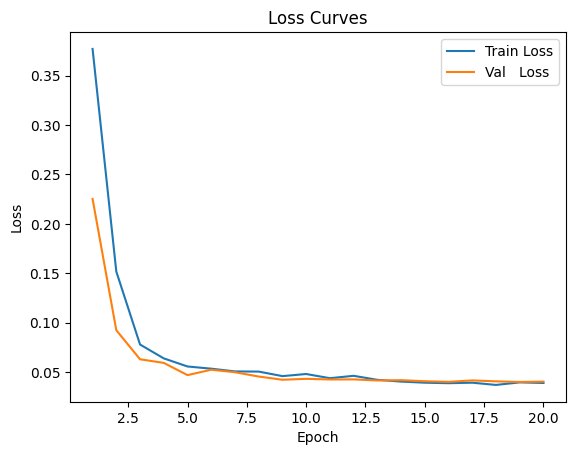

In [ ]:
plt.figure()
plt.figure()
plt.plot(history.epoch, history.train_loss, label="Train Loss")
plt.plot(history.epoch, history.val_loss,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss Curves")
plt.show()


**AUROC vs. Epoch**

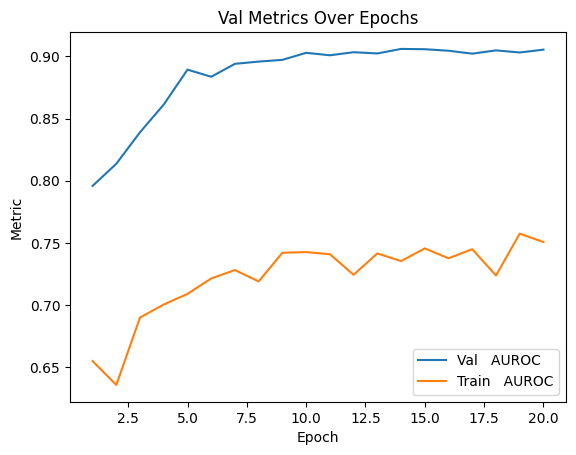

In [ ]:
plt.figure()
plt.plot(history.epoch, history.val_auroc,    label="Val   AUROC")
plt.plot(history.epoch, history.train_auroc,    label="Train   AUROC")
plt.xlabel("Epoch"); plt.ylabel("Metric")
plt.legend(); plt.title("Val Metrics Over Epochs")
plt.show()


##Threshold Analysis on Final Epoch

In [ ]:
def get_epoch_preds(epoch_idx, threshold=0.5):
    """
    Returns (filenames, y_true, y_prob, y_pred) for epoch `epoch_idx` (0-based),
    where y_pred is computed by thresholding y_prob.
    """
    files  = all_epoch_files[epoch_idx]
    y_true = np.array(all_epoch_true[epoch_idx])
    y_prob = np.array(all_epoch_prob[epoch_idx])
    y_pred = (y_prob >= threshold).astype(int)
    return files, y_true, y_prob, y_pred

In [ ]:
#best_epoch = 10
# - files:      list of validation filenames
# - y_true:     ground-truth labels (0 or 1)
# - y_prob:     predicted probabilities from the model (after sigmoid)
# - y_pred:     binary predictions using the threshold (by default,0.5)
files, y_true, y_prob, y_pred = get_epoch_preds(best_epoch - 1)


**ROC Curve with Youden Poin**

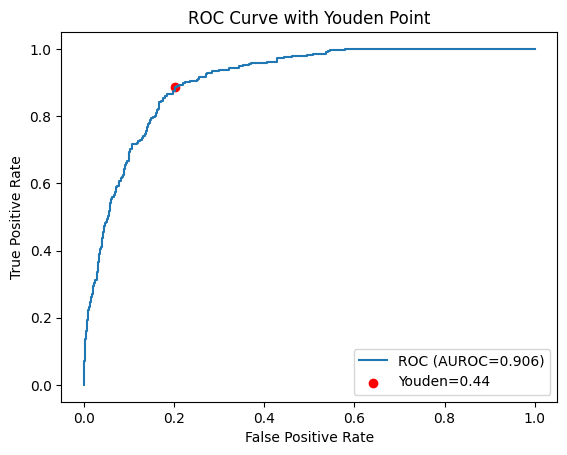

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
J = tpr - fpr
idx = J.argmax()
youden_thresh = thresholds[idx]

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUROC={history.val_auroc.max():.3f})")
plt.scatter(fpr[idx], tpr[idx], color="red", label=f"Youden={youden_thresh:.2f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.title("ROC Curve with Youden Point")
plt.show()


**Precision-Recall Curve**

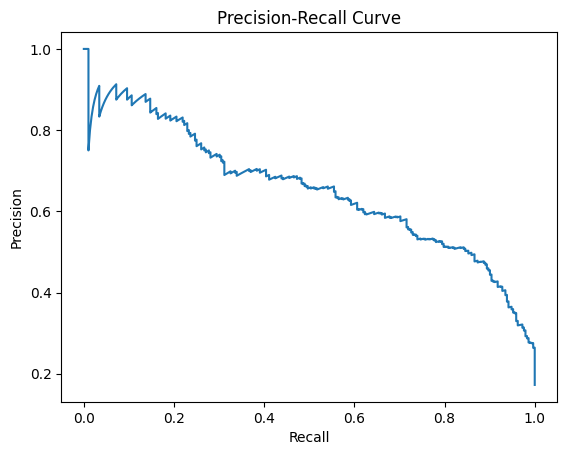

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

**Confusion Matrices at Both Thresholds**

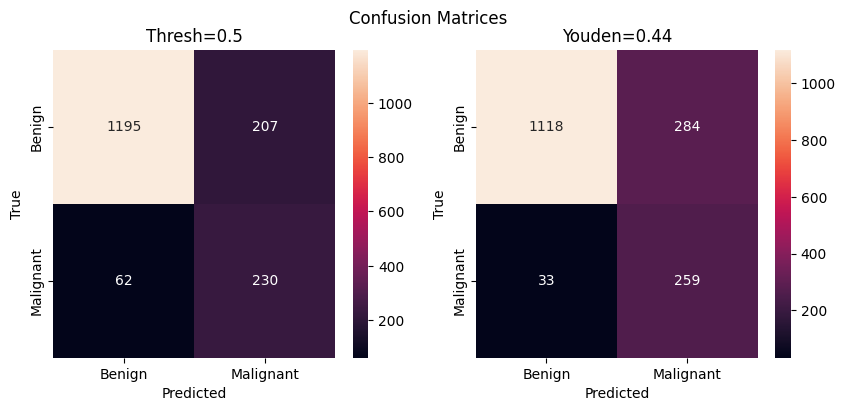

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, (thr, title) in zip(axes, [(0.5, "Thresh=0.5"), (youden_thresh, f"Youden={youden_thresh:.2f}")]):
    cm = confusion_matrix(y_true, (y_prob >= thr).astype(
      int))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax,
                xticklabels=["Benign","Malignant"], yticklabels=["Benign","Malignant"])
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.suptitle("Confusion Matrices")
plt.show()


##Validation Classification Reports

In [ ]:
from sklearn.metrics import f1_score

auroc_at_x = history.val_auroc.iloc[best_epoch - 1]
print(f"AUROC at epoch {best_epoch} = {auroc_at_x:.4f}")

for thr in [0.5, youden_thresh]:
    print(f"--- Classification Report @ threshold = {thr:.2f} ---")
    y_pred_thr = (y_prob >= thr).astype(int)
    print(classification_report(y_true, y_pred_thr, target_names=["Benign","Malignant"]))

    balacc = balanced_accuracy_score(y_true, y_pred_thr)
    macro_f1 = f1_score(y_true, y_pred_thr, average="macro")

    print(f"Balanced Accuracy: {balacc:.3f}")
    print(f"Macro F1 Score:    {macro_f1:.3f}")


AUROC at epoch 14 = 0.9060
--- Classification Report @ threshold = 0.50 ---
              precision    recall  f1-score   support

      Benign       0.95      0.85      0.90      1402
   Malignant       0.53      0.79      0.63       292

    accuracy                           0.84      1694
   macro avg       0.74      0.82      0.76      1694
weighted avg       0.88      0.84      0.85      1694

Balanced Accuracy: 0.820
Macro F1 Score:    0.765
--- Classification Report @ threshold = 0.44 ---
              precision    recall  f1-score   support

      Benign       0.97      0.80      0.88      1402
   Malignant       0.48      0.89      0.62       292

    accuracy                           0.81      1694
   macro avg       0.72      0.84      0.75      1694
weighted avg       0.89      0.81      0.83      1694

Balanced Accuracy: 0.842
Macro F1 Score:    0.748


In [ ]:
########################################################END

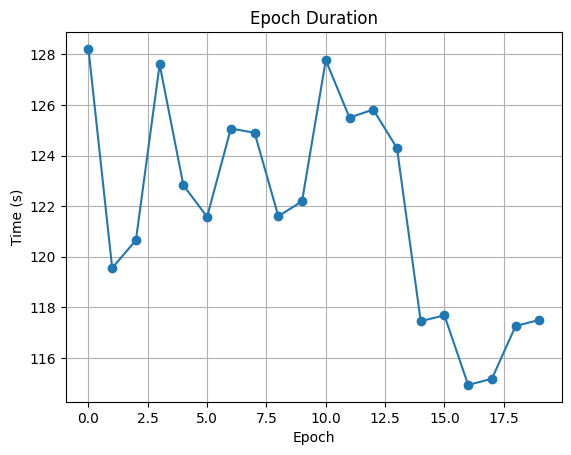

In [ ]:
plt.plot(epoch_times, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Epoch Duration")
plt.grid(True)
plt.show()

In [ ]:
def print_correct_diagnoses(epoch_idx, thresholds=[0.50, 0.37]):
    for thresh in thresholds:
        print(f"\n--- Threshold = {thresh:.2f} ---")
        _, y_true, _, y_pred = get_epoch_preds(epoch_idx, threshold=thresh)

        total_malignant = (y_true == 1).sum()
        total_benign    = (y_true == 0).sum()

        correct_malignant = ((y_true == 1) & (y_pred == 1)).sum()
        correct_benign    = ((y_true == 0) & (y_pred == 0)).sum()

        pct_malignant = 100 * correct_malignant / total_malignant
        pct_benign    = 100 * correct_benign    / total_benign

        print(f"Correct cancer diagnoses:     {correct_malignant}/{total_malignant} = {pct_malignant:.2f}%")
        print(f"Correct non-cancer diagnoses: {correct_benign}/{total_benign} = {pct_benign:.2f}%")

print_correct_diagnoses(epoch_idx=best_epoch-1, thresholds=[0.50, youden_thresh])



--- Threshold = 0.50 ---
Correct cancer diagnoses:     230/292 = 78.77%
Correct non-cancer diagnoses: 1195/1402 = 85.24%

--- Threshold = 0.44 ---
Correct cancer diagnoses:     259/292 = 88.70%
Correct non-cancer diagnoses: 1118/1402 = 79.74%


#Test the model

## Helper Functions

In [ ]:
def compute_auroc_ci(y_true, y_prob, n_bootstraps=1000, seed=42):
    """
    Computes AUROC with a 95% confidence interval using bootstrapping.

    Parameters:
        y_true (array-like): Ground truth binary labels (0 or 1)
        y_prob (array-like): Predicted probabilities
        n_bootstraps (int): Number of bootstrap iterations
        seed (int): Random seed for reproducibility

    Returns:
        auroc (float), ci_lower (float), ci_upper (float)
    """

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    auroc = roc_auc_score(y_true, y_prob)

    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = rng.choice(len(y_true), size=len(y_true), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_prob[indices])
        bootstrapped_scores.append(score)

    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return auroc, ci_lower, ci_upper


##Test the model

In [ ]:
THRESHOLD = youden_thresh

In [ ]:
model = timm.create_model(
    "efficientnet_b3",
    pretrained=True,
    num_classes=1
)

model.load_state_dict(torch.load("checkpoints/best_model.pt"))
model.to(device)


RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Unexpected key(s) in state_dict: "blocks.0.1.conv_dw.weight", "blocks.0.1.bn1.weight", "blocks.0.1.bn1.bias", "blocks.0.1.bn1.running_mean", "blocks.0.1.bn1.running_var", "blocks.0.1.bn1.num_batches_tracked", "blocks.0.1.se.conv_reduce.weight", "blocks.0.1.se.conv_reduce.bias", "blocks.0.1.se.conv_expand.weight", "blocks.0.1.se.conv_expand.bias", "blocks.0.1.conv_pw.weight", "blocks.0.1.bn2.weight", "blocks.0.1.bn2.bias", "blocks.0.1.bn2.running_mean", "blocks.0.1.bn2.running_var", "blocks.0.1.bn2.num_batches_tracked", "blocks.1.2.conv_pw.weight", "blocks.1.2.bn1.weight", "blocks.1.2.bn1.bias", "blocks.1.2.bn1.running_mean", "blocks.1.2.bn1.running_var", "blocks.1.2.bn1.num_batches_tracked", "blocks.1.2.conv_dw.weight", "blocks.1.2.bn2.weight", "blocks.1.2.bn2.bias", "blocks.1.2.bn2.running_mean", "blocks.1.2.bn2.running_var", "blocks.1.2.bn2.num_batches_tracked", "blocks.1.2.se.conv_reduce.weight", "blocks.1.2.se.conv_reduce.bias", "blocks.1.2.se.conv_expand.weight", "blocks.1.2.se.conv_expand.bias", "blocks.1.2.conv_pwl.weight", "blocks.1.2.bn3.weight", "blocks.1.2.bn3.bias", "blocks.1.2.bn3.running_mean", "blocks.1.2.bn3.running_var", "blocks.1.2.bn3.num_batches_tracked", "blocks.2.2.conv_pw.weight", "blocks.2.2.bn1.weight", "blocks.2.2.bn1.bias", "blocks.2.2.bn1.running_mean", "blocks.2.2.bn1.running_var", "blocks.2.2.bn1.num_batches_tracked", "blocks.2.2.conv_dw.weight", "blocks.2.2.bn2.weight", "blocks.2.2.bn2.bias", "blocks.2.2.bn2.running_mean", "blocks.2.2.bn2.running_var", "blocks.2.2.bn2.num_batches_tracked", "blocks.2.2.se.conv_reduce.weight", "blocks.2.2.se.conv_reduce.bias", "blocks.2.2.se.conv_expand.weight", "blocks.2.2.se.conv_expand.bias", "blocks.2.2.conv_pwl.weight", "blocks.2.2.bn3.weight", "blocks.2.2.bn3.bias", "blocks.2.2.bn3.running_mean", "blocks.2.2.bn3.running_var", "blocks.2.2.bn3.num_batches_tracked", "blocks.3.3.conv_pw.weight", "blocks.3.3.bn1.weight", "blocks.3.3.bn1.bias", "blocks.3.3.bn1.running_mean", "blocks.3.3.bn1.running_var", "blocks.3.3.bn1.num_batches_tracked", "blocks.3.3.conv_dw.weight", "blocks.3.3.bn2.weight", "blocks.3.3.bn2.bias", "blocks.3.3.bn2.running_mean", "blocks.3.3.bn2.running_var", "blocks.3.3.bn2.num_batches_tracked", "blocks.3.3.se.conv_reduce.weight", "blocks.3.3.se.conv_reduce.bias", "blocks.3.3.se.conv_expand.weight", "blocks.3.3.se.conv_expand.bias", "blocks.3.3.conv_pwl.weight", "blocks.3.3.bn3.weight", "blocks.3.3.bn3.bias", "blocks.3.3.bn3.running_mean", "blocks.3.3.bn3.running_var", "blocks.3.3.bn3.num_batches_tracked", "blocks.3.4.conv_pw.weight", "blocks.3.4.bn1.weight", "blocks.3.4.bn1.bias", "blocks.3.4.bn1.running_mean", "blocks.3.4.bn1.running_var", "blocks.3.4.bn1.num_batches_tracked", "blocks.3.4.conv_dw.weight", "blocks.3.4.bn2.weight", "blocks.3.4.bn2.bias", "blocks.3.4.bn2.running_mean", "blocks.3.4.bn2.running_var", "blocks.3.4.bn2.num_batches_tracked", "blocks.3.4.se.conv_reduce.weight", "blocks.3.4.se.conv_reduce.bias", "blocks.3.4.se.conv_expand.weight", "blocks.3.4.se.conv_expand.bias", "blocks.3.4.conv_pwl.weight", "blocks.3.4.bn3.weight", "blocks.3.4.bn3.bias", "blocks.3.4.bn3.running_mean", "blocks.3.4.bn3.running_var", "blocks.3.4.bn3.num_batches_tracked", "blocks.4.3.conv_pw.weight", "blocks.4.3.bn1.weight", "blocks.4.3.bn1.bias", "blocks.4.3.bn1.running_mean", "blocks.4.3.bn1.running_var", "blocks.4.3.bn1.num_batches_tracked", "blocks.4.3.conv_dw.weight", "blocks.4.3.bn2.weight", "blocks.4.3.bn2.bias", "blocks.4.3.bn2.running_mean", "blocks.4.3.bn2.running_var", "blocks.4.3.bn2.num_batches_tracked", "blocks.4.3.se.conv_reduce.weight", "blocks.4.3.se.conv_reduce.bias", "blocks.4.3.se.conv_expand.weight", "blocks.4.3.se.conv_expand.bias", "blocks.4.3.conv_pwl.weight", "blocks.4.3.bn3.weight", "blocks.4.3.bn3.bias", "blocks.4.3.bn3.running_mean", "blocks.4.3.bn3.running_var", "blocks.4.3.bn3.num_batches_tracked", "blocks.4.4.conv_pw.weight", "blocks.4.4.bn1.weight", "blocks.4.4.bn1.bias", "blocks.4.4.bn1.running_mean", "blocks.4.4.bn1.running_var", "blocks.4.4.bn1.num_batches_tracked", "blocks.4.4.conv_dw.weight", "blocks.4.4.bn2.weight", "blocks.4.4.bn2.bias", "blocks.4.4.bn2.running_mean", "blocks.4.4.bn2.running_var", "blocks.4.4.bn2.num_batches_tracked", "blocks.4.4.se.conv_reduce.weight", "blocks.4.4.se.conv_reduce.bias", "blocks.4.4.se.conv_expand.weight", "blocks.4.4.se.conv_expand.bias", "blocks.4.4.conv_pwl.weight", "blocks.4.4.bn3.weight", "blocks.4.4.bn3.bias", "blocks.4.4.bn3.running_mean", "blocks.4.4.bn3.running_var", "blocks.4.4.bn3.num_batches_tracked", "blocks.5.4.conv_pw.weight", "blocks.5.4.bn1.weight", "blocks.5.4.bn1.bias", "blocks.5.4.bn1.running_mean", "blocks.5.4.bn1.running_var", "blocks.5.4.bn1.num_batches_tracked", "blocks.5.4.conv_dw.weight", "blocks.5.4.bn2.weight", "blocks.5.4.bn2.bias", "blocks.5.4.bn2.running_mean", "blocks.5.4.bn2.running_var", "blocks.5.4.bn2.num_batches_tracked", "blocks.5.4.se.conv_reduce.weight", "blocks.5.4.se.conv_reduce.bias", "blocks.5.4.se.conv_expand.weight", "blocks.5.4.se.conv_expand.bias", "blocks.5.4.conv_pwl.weight", "blocks.5.4.bn3.weight", "blocks.5.4.bn3.bias", "blocks.5.4.bn3.running_mean", "blocks.5.4.bn3.running_var", "blocks.5.4.bn3.num_batches_tracked", "blocks.5.5.conv_pw.weight", "blocks.5.5.bn1.weight", "blocks.5.5.bn1.bias", "blocks.5.5.bn1.running_mean", "blocks.5.5.bn1.running_var", "blocks.5.5.bn1.num_batches_tracked", "blocks.5.5.conv_dw.weight", "blocks.5.5.bn2.weight", "blocks.5.5.bn2.bias", "blocks.5.5.bn2.running_mean", "blocks.5.5.bn2.running_var", "blocks.5.5.bn2.num_batches_tracked", "blocks.5.5.se.conv_reduce.weight", "blocks.5.5.se.conv_reduce.bias", "blocks.5.5.se.conv_expand.weight", "blocks.5.5.se.conv_expand.bias", "blocks.5.5.conv_pwl.weight", "blocks.5.5.bn3.weight", "blocks.5.5.bn3.bias", "blocks.5.5.bn3.running_mean", "blocks.5.5.bn3.running_var", "blocks.5.5.bn3.num_batches_tracked", "blocks.6.1.conv_pw.weight", "blocks.6.1.bn1.weight", "blocks.6.1.bn1.bias", "blocks.6.1.bn1.running_mean", "blocks.6.1.bn1.running_var", "blocks.6.1.bn1.num_batches_tracked", "blocks.6.1.conv_dw.weight", "blocks.6.1.bn2.weight", "blocks.6.1.bn2.bias", "blocks.6.1.bn2.running_mean", "blocks.6.1.bn2.running_var", "blocks.6.1.bn2.num_batches_tracked", "blocks.6.1.se.conv_reduce.weight", "blocks.6.1.se.conv_reduce.bias", "blocks.6.1.se.conv_expand.weight", "blocks.6.1.se.conv_expand.bias", "blocks.6.1.conv_pwl.weight", "blocks.6.1.bn3.weight", "blocks.6.1.bn3.bias", "blocks.6.1.bn3.running_mean", "blocks.6.1.bn3.running_var", "blocks.6.1.bn3.num_batches_tracked". 
	size mismatch for conv_stem.weight: copying a param with shape torch.Size([40, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.conv_dw.weight: copying a param with shape torch.Size([40, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for blocks.0.0.bn1.weight: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.running_mean: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.bn1.running_var: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.se.conv_reduce.weight: copying a param with shape torch.Size([10, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 32, 1, 1]).
	size mismatch for blocks.0.0.se.conv_reduce.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for blocks.0.0.se.conv_expand.weight: copying a param with shape torch.Size([40, 10, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 8, 1, 1]).
	size mismatch for blocks.0.0.se.conv_expand.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for blocks.0.0.conv_pw.weight: copying a param with shape torch.Size([24, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 32, 1, 1]).
	size mismatch for blocks.0.0.bn2.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for blocks.0.0.bn2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for blocks.0.0.bn2.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for blocks.0.0.bn2.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for blocks.1.0.conv_pw.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 16, 1, 1]).
	size mismatch for blocks.1.0.bn1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.conv_dw.weight: copying a param with shape torch.Size([144, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 1, 3, 3]).
	size mismatch for blocks.1.0.bn2.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.bn2.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.se.conv_reduce.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 96, 1, 1]).
	size mismatch for blocks.1.0.se.conv_reduce.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for blocks.1.0.se.conv_expand.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 4, 1, 1]).
	size mismatch for blocks.1.0.se.conv_expand.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for blocks.1.0.conv_pwl.weight: copying a param with shape torch.Size([32, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1]).
	size mismatch for blocks.1.0.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.0.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.0.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.0.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.1.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for blocks.1.1.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.conv_dw.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([144, 1, 3, 3]).
	size mismatch for blocks.1.1.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for blocks.1.1.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for blocks.1.1.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for blocks.1.1.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.1.1.conv_pwl.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 144, 1, 1]).
	size mismatch for blocks.1.1.bn3.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.1.bn3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.1.bn3.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.1.1.bn3.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for blocks.2.0.conv_pw.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for blocks.2.0.bn1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.conv_dw.weight: copying a param with shape torch.Size([192, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([144, 1, 5, 5]).
	size mismatch for blocks.2.0.bn2.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.bn2.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.se.conv_reduce.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for blocks.2.0.se.conv_reduce.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for blocks.2.0.se.conv_expand.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for blocks.2.0.se.conv_expand.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for blocks.2.0.conv_pwl.weight: copying a param with shape torch.Size([48, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 144, 1, 1]).
	size mismatch for blocks.2.0.bn3.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.0.bn3.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.0.bn3.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.0.bn3.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.1.conv_pw.weight: copying a param with shape torch.Size([288, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for blocks.2.1.bn1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.conv_dw.weight: copying a param with shape torch.Size([288, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 5, 5]).
	size mismatch for blocks.2.1.bn2.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.bn2.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.se.conv_reduce.weight: copying a param with shape torch.Size([12, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for blocks.2.1.se.conv_reduce.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for blocks.2.1.se.conv_expand.weight: copying a param with shape torch.Size([288, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for blocks.2.1.se.conv_expand.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.2.1.conv_pwl.weight: copying a param with shape torch.Size([48, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for blocks.2.1.bn3.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.1.bn3.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.1.bn3.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.2.1.bn3.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for blocks.3.0.conv_pw.weight: copying a param with shape torch.Size([288, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for blocks.3.0.bn1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.conv_dw.weight: copying a param with shape torch.Size([288, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for blocks.3.0.bn2.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.bn2.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.se.conv_reduce.weight: copying a param with shape torch.Size([12, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for blocks.3.0.se.conv_reduce.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for blocks.3.0.se.conv_expand.weight: copying a param with shape torch.Size([288, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for blocks.3.0.se.conv_expand.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for blocks.3.0.conv_pwl.weight: copying a param with shape torch.Size([96, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 240, 1, 1]).
	size mismatch for blocks.3.0.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.0.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.conv_pw.weight: copying a param with shape torch.Size([576, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.3.1.bn1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.conv_dw.weight: copying a param with shape torch.Size([576, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for blocks.3.1.bn2.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.bn2.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.se.conv_reduce.weight: copying a param with shape torch.Size([24, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.3.1.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.3.1.se.conv_expand.weight: copying a param with shape torch.Size([576, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.3.1.se.conv_expand.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.1.conv_pwl.weight: copying a param with shape torch.Size([96, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for blocks.3.1.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.1.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.conv_pw.weight: copying a param with shape torch.Size([576, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.3.2.bn1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.conv_dw.weight: copying a param with shape torch.Size([576, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for blocks.3.2.bn2.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.bn2.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.se.conv_reduce.weight: copying a param with shape torch.Size([24, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.3.2.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.3.2.se.conv_expand.weight: copying a param with shape torch.Size([576, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.3.2.se.conv_expand.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.3.2.conv_pwl.weight: copying a param with shape torch.Size([96, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for blocks.3.2.bn3.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.3.2.bn3.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for blocks.4.0.conv_pw.weight: copying a param with shape torch.Size([576, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for blocks.4.0.bn1.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn1.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.conv_dw.weight: copying a param with shape torch.Size([576, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([480, 1, 5, 5]).
	size mismatch for blocks.4.0.bn2.weight: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.running_mean: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.bn2.running_var: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.se.conv_reduce.weight: copying a param with shape torch.Size([24, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for blocks.4.0.se.conv_reduce.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for blocks.4.0.se.conv_expand.weight: copying a param with shape torch.Size([576, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for blocks.4.0.se.conv_expand.bias: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for blocks.4.0.conv_pwl.weight: copying a param with shape torch.Size([136, 576, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 480, 1, 1]).
	size mismatch for blocks.4.0.bn3.weight: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.0.bn3.bias: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.0.bn3.running_mean: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.0.bn3.running_var: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.1.conv_pw.weight: copying a param with shape torch.Size([816, 136, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for blocks.4.1.bn1.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn1.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn1.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn1.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.conv_dw.weight: copying a param with shape torch.Size([816, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.4.1.bn2.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn2.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn2.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.bn2.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.se.conv_reduce.weight: copying a param with shape torch.Size([34, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for blocks.4.1.se.conv_reduce.bias: copying a param with shape torch.Size([34]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for blocks.4.1.se.conv_expand.weight: copying a param with shape torch.Size([816, 34, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for blocks.4.1.se.conv_expand.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.1.conv_pwl.weight: copying a param with shape torch.Size([136, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 672, 1, 1]).
	size mismatch for blocks.4.1.bn3.weight: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.1.bn3.bias: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.1.bn3.running_mean: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.1.bn3.running_var: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.2.conv_pw.weight: copying a param with shape torch.Size([816, 136, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for blocks.4.2.bn1.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn1.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn1.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn1.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.conv_dw.weight: copying a param with shape torch.Size([816, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.4.2.bn2.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn2.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn2.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.bn2.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.se.conv_reduce.weight: copying a param with shape torch.Size([34, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for blocks.4.2.se.conv_reduce.bias: copying a param with shape torch.Size([34]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for blocks.4.2.se.conv_expand.weight: copying a param with shape torch.Size([816, 34, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for blocks.4.2.se.conv_expand.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.4.2.conv_pwl.weight: copying a param with shape torch.Size([136, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 672, 1, 1]).
	size mismatch for blocks.4.2.bn3.weight: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.2.bn3.bias: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.2.bn3.running_mean: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.4.2.bn3.running_var: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for blocks.5.0.conv_pw.weight: copying a param with shape torch.Size([816, 136, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for blocks.5.0.bn1.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn1.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn1.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn1.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.conv_dw.weight: copying a param with shape torch.Size([816, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for blocks.5.0.bn2.weight: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn2.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn2.running_mean: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.bn2.running_var: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.se.conv_reduce.weight: copying a param with shape torch.Size([34, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for blocks.5.0.se.conv_reduce.bias: copying a param with shape torch.Size([34]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for blocks.5.0.se.conv_expand.weight: copying a param with shape torch.Size([816, 34, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for blocks.5.0.se.conv_expand.bias: copying a param with shape torch.Size([816]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for blocks.5.0.conv_pwl.weight: copying a param with shape torch.Size([232, 816, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 672, 1, 1]).
	size mismatch for blocks.5.0.bn3.weight: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.0.bn3.bias: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.0.bn3.running_mean: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.0.bn3.running_var: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.1.conv_pw.weight: copying a param with shape torch.Size([1392, 232, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for blocks.5.1.bn1.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn1.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn1.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn1.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.conv_dw.weight: copying a param with shape torch.Size([1392, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for blocks.5.1.bn2.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn2.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn2.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.bn2.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.se.conv_reduce.weight: copying a param with shape torch.Size([58, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for blocks.5.1.se.conv_reduce.bias: copying a param with shape torch.Size([58]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for blocks.5.1.se.conv_expand.weight: copying a param with shape torch.Size([1392, 58, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for blocks.5.1.se.conv_expand.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.1.conv_pwl.weight: copying a param with shape torch.Size([232, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for blocks.5.1.bn3.weight: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.1.bn3.bias: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.1.bn3.running_mean: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.1.bn3.running_var: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.2.conv_pw.weight: copying a param with shape torch.Size([1392, 232, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for blocks.5.2.bn1.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn1.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn1.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn1.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.conv_dw.weight: copying a param with shape torch.Size([1392, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for blocks.5.2.bn2.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn2.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn2.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.bn2.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.se.conv_reduce.weight: copying a param with shape torch.Size([58, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for blocks.5.2.se.conv_reduce.bias: copying a param with shape torch.Size([58]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for blocks.5.2.se.conv_expand.weight: copying a param with shape torch.Size([1392, 58, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for blocks.5.2.se.conv_expand.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.2.conv_pwl.weight: copying a param with shape torch.Size([232, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for blocks.5.2.bn3.weight: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.2.bn3.bias: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.2.bn3.running_mean: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.2.bn3.running_var: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.3.conv_pw.weight: copying a param with shape torch.Size([1392, 232, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for blocks.5.3.bn1.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn1.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn1.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn1.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.conv_dw.weight: copying a param with shape torch.Size([1392, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for blocks.5.3.bn2.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn2.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn2.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.bn2.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.se.conv_reduce.weight: copying a param with shape torch.Size([58, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for blocks.5.3.se.conv_reduce.bias: copying a param with shape torch.Size([58]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for blocks.5.3.se.conv_expand.weight: copying a param with shape torch.Size([1392, 58, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for blocks.5.3.se.conv_expand.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.5.3.conv_pwl.weight: copying a param with shape torch.Size([232, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for blocks.5.3.bn3.weight: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.3.bn3.bias: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.3.bn3.running_mean: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.5.3.bn3.running_var: copying a param with shape torch.Size([232]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for blocks.6.0.conv_pw.weight: copying a param with shape torch.Size([1392, 232, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for blocks.6.0.bn1.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn1.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn1.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn1.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.conv_dw.weight: copying a param with shape torch.Size([1392, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1152, 1, 3, 3]).
	size mismatch for blocks.6.0.bn2.weight: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn2.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn2.running_mean: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.bn2.running_var: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.se.conv_reduce.weight: copying a param with shape torch.Size([58, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for blocks.6.0.se.conv_reduce.bias: copying a param with shape torch.Size([58]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for blocks.6.0.se.conv_expand.weight: copying a param with shape torch.Size([1392, 58, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for blocks.6.0.se.conv_expand.bias: copying a param with shape torch.Size([1392]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for blocks.6.0.conv_pwl.weight: copying a param with shape torch.Size([384, 1392, 1, 1]) from checkpoint, the shape in current model is torch.Size([320, 1152, 1, 1]).
	size mismatch for blocks.6.0.bn3.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for blocks.6.0.bn3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for blocks.6.0.bn3.running_mean: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for blocks.6.0.bn3.running_var: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for conv_head.weight: copying a param with shape torch.Size([1536, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([1280, 320, 1, 1]).
	size mismatch for bn2.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.running_mean: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for bn2.running_var: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for classifier.weight: copying a param with shape torch.Size([1, 1536]) from checkpoint, the shape in current model is torch.Size([1, 1280]).

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from sklearn.metrics import roc_curve, recall_score, balanced_accuracy_score, f1_score

def get_tta():
    return [
        transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224)]),
        transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(p=1.0)]),
        transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomVerticalFlip(p=1.0)]),
        transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.RandomRotation(90)]),
    ]

def infer_with_tta(model, loader, tta, device):
    y_true, y_prob = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = torch.stack([model(t(inputs)) for t in tta]).mean(0).squeeze(-1)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_prob.extend(probs.tolist())
            y_true.extend(labels.cpu().tolist())
    return np.array(y_true), np.array(y_prob)

def find_tau95(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr
    idx = np.where(specificity >= 0.95)[0]
    return thresholds[idx[-1]] if idx.size else 0.5

def compute_metrics(y_true, y_prob, compute_auroc_ci):
    auroc, ci_lower, ci_upper = compute_auroc_ci(y_true, y_prob)
    tau95 = find_tau95(y_true, y_prob)
    y_pred95 = (y_prob >= tau95).astype(int)
    recall95 = recall_score(y_true, y_pred95)
    bal_acc = balanced_accuracy_score(y_true, y_pred95)
    macro_f1 = f1_score(y_true, y_pred95, average='macro')
    return auroc, ci_lower, ci_upper, tau95, recall95, bal_acc, macro_f1

tta = get_tta()
y_true, y_prob = infer_with_tta(model, test_loader, tta, device)
auroc, ci_l, ci_u, tau95, recall95, bal_acc, macro_f1 = compute_metrics(y_true, y_prob, compute_auroc_ci)




print(f"AUROC = {auroc:.3f} (95% CI: {ci_l:.3f} – {ci_u:.3f})")
print(f"Threshold for 95% specificity: {tau95:.3f}")
print(f"Recall @ 95% Spec:           {recall95:.3f}")
print(f"Balanced Accuracy @ τ95:    {bal_acc:.3f}")
print(f"Macro F1 Score @ τ95:       {macro_f1:.3f}")



In [ ]:
y_pred = (y_prob >= tau95).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
"""# 1) Initialize Python lists
y_true = []
y_prob = []

model.eval()
with torch.no_grad():
    for inputs, labels, _ in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 2) Forward + sigmoid in one shot, keep as CPU list
        outputs = model(inputs).squeeze(-1)        # [B]
        probs = torch.sigmoid(outputs).cpu().tolist()

        # 3) Extend your lists directly
        y_prob.extend(probs)
        y_true.extend(labels.cpu().tolist())

# 4) Now convert to NumPy (for metrics) if you need:
import numpy as np
y_true = np.array(y_true)
y_prob = np.array(y_prob)
"""

In [ ]:
"""# 1) AUROC + CI
test_auroc, ci_lower, ci_upper = compute_auroc_ci(y_true, y_prob)
print(f"AUROC = {test_auroc:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})")

# 2) Find threshold for 95% specificity
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
specificity = 1 - fpr
# pick the highest threshold that still gives specificity >= 0.95
idx = np.where(specificity >= 0.95)[0]
if len(idx) == 0:
    tau95 = 0.5  # fallback
else:
    tau95 = thresholds[idx[-1]]
print(f"Threshold for 95% specificity: {tau95:.3f}")

# 3) Binarize at that threshold
test_y_pred95 = (y_prob >= tau95).astype(int)

# 4) Other metrics at τ95
test_recall95 = recall_score(y_true, test_y_pred95)
test_bal_acc  = balanced_accuracy_score(y_true, test_y_pred95)
test_macro_f1 = f1_score(y_true, test_y_pred95, average="macro")

print(f"Recall @ 95% Spec:           {test_recall95:.3f}")
print(f"Balanced Accuracy @ τ95:    {test_bal_acc:.3f}")
print(f"Macro F1 Score @ τ95:       {test_macro_f1:.3f}")"""

#Save Run

In [ ]:
results_md_path = "/content/drive/MyDrive/results.md"
EXPERIMENT_VERSION = "Baseline v02"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

summary_lines = [
    f"## {EXPERIMENT_VERSION} — {timestamp}\n",
    f"- Dataset: lesions_v1",
    f"- Dataset Split 1/0: 40%/60%",
    f"- FOCAL BCE: Y=1.5, alpha=0.7",
    f"- Train/Val/Test: 70/15/15",
    f"- Learning rate: 0.0003",
    f"- Batch size: Batch 32 → effective 64",
    f"- Epochs: {best_epoch}",
    f"- Augmentations: RandomResizedCrop, H/V Flip, Rotation(15°), ColorJitter",
    f"- Mixup: alpha = 0.2",
    f"- Seed: 42",
    f"- Validation AUROC: {auroc_at_x:.4f}",
    f"- Test AUROC: {test_auroc:.3f}",
    f"- Test Macro F1: {test_macro_f1:.3f}",
    f"- Test Balanced Accuracy: {test_bal_acc:.3f}",
    f"- Test Recall (sensitivity): {test_recall95:.3f}",
    f"- Threshold (from val): {THRESHOLD:.2f}\n",
    f"- Notes:previous + b3 ",
    "---\n"
]

with open(results_md_path, "a") as f:
    f.write("\n".join(summary_lines))

coisas que ta:

```
melhores resultados:

y=1.5 apha = 0.7
split de 30/70 para o treino de malignos
com mixup em todos menos ultimos 3 epochs


testando:
0.5 alpha em vez de 0.5 e 2 po Y
mixup e cutmix na fucncao train one epoch
```

TODO:
marcar tempos e memoria
guardar os pesos

TODO REPORT:Falar como se ecnontravam as coisas do dataset, por exemplo é muito mais facil fazer download do zip do que da api por isso foi escolhido essa opção.fazer download através da api é extramemente lento .
-ver da randomnsss
-Free Colab / Kaggle GPU ⇒ T4 16 GB; design your model to stay under 8 GB
VRAM and ≤ 4 h GPU total per experiment.
- adiconar a cena dos heatmaps e perceber como fucniona

In [ ]:
# Configuration
n = 1  # Number of correct and incorrect examples to show
shown_correct = 0
shown_wrong = 0
THRESHOLD = THRESHOLD

# Model in eval mode
model.eval()

# Set Grad-CAM target layer (EfficientNet from timm)
target_layers = [model.conv_head]
cam = GradCAM(model=model, target_layers=target_layers)

# Shuffle test dataset indices
indices = list(range(len(test_dataset)))
random.shuffle(indices)

# Loop through shuffled test samples
for idx in indices:
    image_tensor, label, _ = test_dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = int(prob >= THRESHOLD)

    is_correct = (pred == label)

    # Check if we need to show this example
    if (is_correct and shown_correct < n) or (not is_correct and shown_wrong < n):
        # Unnormalize image for display
        input_np = image_tensor.permute(1, 2, 0).numpy()
        input_np = (input_np * 0.5 + 0.5).clip(0, 1)

        # Grad-CAM visualization
        input_tensor.requires_grad_()
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0]
        cam_image = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)

        # Plot image
        plt.figure(figsize=(5, 5))
        plt.imshow(cam_image)
        plt.title(f"{'Correct' if is_correct else 'Incorrect'} | Label: {label} | Pred: {pred} | p={prob:.2f}")
        plt.axis('off')
        plt.show()

        # Update counters
        if is_correct:
            shown_correct += 1
        else:
            shown_wrong += 1

    # Exit if enough examples have been shown
    if shown_correct >= n and shown_wrong >= n:
        break


In [ ]:
"""#vx === Constants ===
n_epochs = 1
FOLD_DIR = "data_v1"
PATH = "/content/ISIC_IMAGES"
batch_size = 32

def get_dataloaders(fold):
    print(f"Loading data for Fold {fold}")
    train_df = pd.read_csv(f"{FOLD_DIR}/fold_{fold}/lesions_train.csv")
    val_df   = pd.read_csv(f"{FOLD_DIR}/fold_{fold}/lesions_val.csv")

    train_dataset = SkinCancerDataset(train_df, PATH, transform=train_transform, return_filename=False)
    val_dataset   = SkinCancerDataset(val_df, PATH, transform=val_transform, return_filename=True)

    # Weighted sampling
    p_m = train_df["label"].mean()
    w_benign = 0.7 / (1.0 - p_m)
    w_malignant = 0.3 / p_m
    sample_weights = train_df["label"].map({0: w_benign, 1: w_malignant}).values
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

def reset_model():
    model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=1)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=30)
    return model, optimizer, scheduler

def train_fold(fold):
    print(f"\n===== Starting Fold {fold} =====\n")
    train_loader, val_loader = get_dataloaders(fold)
    model, optimizer, scheduler = reset_model()

    best_val_auroc = 0.0
    best_epoch = 1
    epoch_times = []
    train_losses, train_aurocs = [], []
    val_losses, val_aurocs = [], []
    all_epoch_true, all_epoch_prob, all_epoch_files = [], [], []

    for epoch in range(1, n_epochs + 1):
        start = time.time()
        print(f"--- Fold {fold} | Epoch {epoch}/{n_epochs} ---")

        # Train
        train_loss, _, train_probs, train_labels, train_auroc = train_one_epoch(train_loader)
        train_losses.append(train_loss)
        train_aurocs.append(train_auroc)

        # Validate
        val_loss, val_auroc, y_true, y_prob, val_files = validate_one_epoch(val_loader)
        val_losses.append(val_loss)
        val_aurocs.append(val_auroc)

        all_epoch_true.append(y_true)
        all_epoch_prob.append(y_prob)
        all_epoch_files.append(val_files)

        print(f"Train Loss: {train_loss:.4f} | AUROC: {train_auroc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | AUROC: {val_auroc:.4f}")

        scheduler.step()

        elapsed = time.time() - start
        epoch_times.append(elapsed)
        print(f"Epoch Time: {elapsed:.1f} sec\n")

        if val_auroc > best_val_auroc:
            best_val_auroc = val_auroc
            best_epoch = epoch
            torch.save(model.state_dict(), f"checkpoints/best_model_fold{fold}.pt")

    print(f"\n✅ Fold {fold} completed. Best AUROC: {best_val_auroc:.4f} (Epoch {best_epoch})\n")

def main():
    print(f"Using device: {device}")
    for fold in range(5):
        train_fold(fold)

# Run everything
main()"""

In [ ]:
"""v1
n_epochs = 10
epoch_times = []

# Metric trackers
train_losses, train_aurocs = [], []
val_losses, val_aurocs     = [], []

# Store raw predictions each epoch
all_epoch_true = []
all_epoch_prob = []
all_epoch_files = []

best_val_auroc = 0.0
best_epoch = 1

print("Starting training...\n")

for epoch in range(1, n_epochs + 1):
    start = time.time()
    print(f"--- Epoch {epoch}/{n_epochs} ---")

    # === Train ===
    train_loss, train_logits, train_probs, train_labels,train_auroc = train_one_epoch(train_loader)
    train_losses.append(train_loss)
    train_aurocs.append(train_auroc)

    # === Validate ===
    val_loss, val_auroc, y_true, y_prob, val_files = validate_one_epoch(val_loader)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)

    # === Save raw predictions for later thresholded analysis ===
    all_epoch_true.append(y_true)
    all_epoch_prob.append(y_prob)
    all_epoch_files.append(val_files)

    # === Print epoch summary (threshold‐independent only) ===
    print(f"Train Loss: {train_loss:.4f} | Train AUROC: {train_auroc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   AUROC: {val_auroc:.4f}\n")

    # === Scheduler Step ===
    scheduler.step()

    # === Timing ===
    elapsed = time.time() - start
    epoch_times.append(elapsed)
    print(f"Epoch Time: {elapsed:.1f} sec\n")

    # === Save model if AUROC improves ===
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_epoch = epoch

        # Save model weights
        torch.save(model.state_dict(), "checkpoints/best_model.pt")

        """
